# Overall goal: Determine if early blind and normally sighted opossums use different strategies for reaching and graasping a food reward
## Specific goal: develop a video data acquisition and analysis pipeline using Python

![i](opossumReaching.png)

The above image shows an early blind opossum performing the "reach-and-grasp" task. I hope to quantify differences in strategy between early blind and normally sighted opossums, in terms of limb kinematics and biomechanics. 

## 1) Prepare to get data: set up cameras
    A) Place 2 video cameras at right angles (one left, and one right)
            Here you can see me using 2 cellphone cameras held in a steel armature at 90 degrees to each other

![i](cameraRigAnnotated.jpg)

    B) make sure each frame rate is as identical as possible
            Both videos taken at 30fps

    C) Used an LED flashlight turning on in view of both cameras to make sure there is a common signal at equivalent times in both cameras
            Left cam: 
                t0 = 0.467 sec from start, frame 14, pic 5; this is when I flash a light in view of both cams

![i](LeftCam_flash.png)

            Right cam: 
                t0 = 6.4 sec from start, frame 192, pic 208; this is when I flash a light in view of both cams
![i](RightCam_flash.png)
                (sorry for the shirtlessness, it was a really hot day)

## 2) synchronize cameras in time
    define a few equivalent frames in videos, so we can check temporal synchronization

    Left cam: 
        t0 = 0.467 sec from start, frame 14, pic 5; this is when I flash a light in view of both cams
        t1 = 33.9 sec from start, frame , pic 593; this is when I let go of checkerboard with my right hand
        t2 = 39.3 sec from start, frame , pic 797; finger furthest toward left
        t3 = 51.15 sec from start, frame , pic 958; change angle of finger  

    Right cam: 
        t0 = 6.4 sec from start, frame 192, pic 208; this is when I flash a light in view of both cams
        t1 = 39.86 sec from start, frame, pic 1045; this is when I let go of checkerboard with my right hand
        t2 = 44.6733 sec from start, frame , pic 1160; finger furthest toward left 
        t3 = 57.13 sec from start, frame , pic 1455; change angle of finger

    t3 - t0 = ~50.733 seconds for both

    Left average frame rate: (958-5)/50.733 = 18.78 fps
    Right average frame rate: (1455-208)/50.733 = 24.58 fps
    
Looks like the exports to images in VLC were inaccurate, and each video wasn't exported at the actual 30fps.
How annoying :(


In [39]:
# if the export frame rate is consistent, we can still work with these stills
# lets make some functions to find equivalent frames in each video, assuming the frames rates are pretty consistent.

# if I wanted to generalize this function for any two videos, I'd add duration, V1 start pic #, V1 end pic #, V2 start pic #, V2 end pic #,  as inputs
def LtoR(Lpic): # Lpic is the picture number from the left cam, for which you want to find the equivalent right ca frame. 
    duration = 50.733; # in seconds
    Lstart = 5; # light flash in 5th exported image for the left cam
    Lend = 958; # last frame with a tracked feature (my hand) for the left cam
    Rstart = 208; # light flash in 208th exported image for the right cam
    Rend = 1455; # last frame with a tracked feature (my hand) for the right cam
    Lpicrate = (duration/(Lend-Lstart)); # calculate the effective frame rate for the exported video still images from left cam
    Rpicrate = (duration/(Rend-Rstart)); # calculate the effective frame rate for the exported video still images from left cam
    time = (Lpic-Lstart+1) * Lpicrate; # find the time in seconds of the frame of interest
    Rpic = (time/Rpicrate) + Rstart-1; # find the pic number in right, given time of event and effective frame rate of exported stills
    Rpic = int(round(Rpic)); # can't have a fraction of a frame, so round
    return Rpic

def RtoL(Rpic): # same as above but from right-to-left
    duration = 50.733;
    Lstart = 5;
    Lend = 958;
    Rstart = 208;
    Rend = 1455;
    Lpicrate = (duration/(Lend-Lstart));
    Rpicrate = (duration/(Rend-Rstart));
    time = (Rpic-Rstart+1) * Rpicrate;
    Lpic = (time/Lpicrate) + Lstart-1;
    Lpic = int(round(Lpic));
    return Lpic


### lets see if these functions work

In [40]:
# I know the start pics and end pics are guaranteed to be temporally equivalent, so lets try those first as our ground truth
Rframe = LtoR(5)

# Rframe SHOULD be 208
print(Rframe)

208


In [41]:
Lframe = RtoL(1455)

# Lframe SHOULD be 958
print(Lframe)

958


### OK, lets see if middle frames work
    I went through and manually found equivalent still pics
        Left:   63, 105, 169, 220, 254, 324, 396, 436, 455, 484, 532,  592,  697,  753,  800,  860,  955
        Right: 463, 507, 580, 642, 678, 747, 830, 871, 889, 918, 964, 1044, 1161, 1219, 1276, 1344, 1450
            
    If these don't work, that means the time between exported images isn't consistent


In [42]:
Rframe = LtoR(63)

# Rframe SHOULD be 463
print(Rframe)

284


### Hmmm... looks like some Lframes predict equivalent Rframes that are almost 200 frames off :(
    this means that VLC didn't export with consistent time bins
    
    I didnt write my own program to open the video frame by frame and save stills because that would be really slow, but in the future I'll write my own function along the lines of the following pseudocode:
    
    vid = openVideo(fileName);
    totalFrames = vid.frameNumbers;
    for frame in totalFrames
        img = vid(frame)
        save(img, formatTag)
        
    For now I'll just go ahead with what I've got, manyally finding congruent frames :/

## 3) Synchronize the cameras is space
    welp. I failed at synchronizing in time, so now lets try to synchronize in space.
    
    To do this I'll try to use opencv, which is a python version of the camera calibration I'm familiar with: http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html
    
    The goal is to get a model of the equivalent [x y z] coordinates for each pixel in each camera's view
    
    To do this I'll use still images taken of a checkerboard of known dimensions viewed through each camera simultaneously
    
    I'm going to start with this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

In [43]:
# for this step we'll need some packages other than the built-in python functions
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [44]:
def getCamCalImages(checkerboardImagesList, squareSideLength, squaresHeight, squaresWidth):
    num_corners = int((squaresWidth-1)*(squaresHeight-1));

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # objp = np.zeros((6*7,3), np.float32)
    objp = np.zeros((num_corners,3), np.float32)
    # objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
    objp[:,:2] = np.mgrid[0:(squaresHeight-1)*squareSideLength:squareSideLength, 0:(squaresWidth-1)*squareSideLength:squareSideLength].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    imgPtsID = []; 
    imageList = [];
    failed = [];
    i = 1;
    for fname in checkerboardImagesList:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (squaresHeight-1,squaresWidth-1),None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            imgPtsID.append([i]*len(corners2)) # all i for N object/image points for a given image, to keep track of which points go with wich image for future plotting
            
            # save the images that worked
            imageList.append([gray]);
            
        else:
            failed.append(fname)
        i = i+1;    
    return imgPtsID, imgpoints, objpoints, imageList, failed

# my video stills exported as scene00000, with 00000 iterating from 1 to N, always with 5 figures
# because I'm lazy I'm making this accept a list of strings. 
# If I weren't lazy I'd build it to accept a vector defines something like vec = 1:end, 
# and then I'd turn these into strings and prepend zeros to make sure all strings are 5 characters long
def makeImageList(direc, numList, tag):
    namesList = [];
    for i in range(len(numList)):
        fname = direc + numList[i] + tag;
        namesList.append(fname);
    return namesList

In [45]:
# define the input parameters
squareSideLength =13; # mm
squaresHeight =7;
squaresWidth =9;
LVidsDirec = 'C:\\Users\\ChrisBresee\\Desktop\\LeftCam\\scene'
RVidsDirec = 'C:\\Users\\ChrisBresee\\Desktop\\RightCam\\scene'

# I'm just manually defining equivalent pics here
LcheckerNums = ['00063', '00105', '00169', '00220', '00254', '00324', '00363', '00396', '00436', '00455', '00484', '00532', '00592'];
RcheckerNums = ['00463', '00507', '00580', '00642', '00678', '00747', '00793', '00830', '00871', '00889', '00918', '00964', '01044'];

# get the full path and file names
checkerboardImagesListL = makeImageList(LVidsDirec, LcheckerNums, '.png')
checkerboardImagesListR = makeImageList(RVidsDirec, RcheckerNums, '.png')

In [46]:
# point the corner-finding code at our pics for one camera, and check if it can find corners in all of them
imgPtsIDL, imgpointsL, objpointsL, imageListL, failedL = getCamCalImages(checkerboardImagesListL, squareSideLength, squaresHeight, squaresWidth)
print(failedL)

['C:\\Users\\ChrisBresee\\Desktop\\LeftCam\\scene00363.png']


### lets look at that image

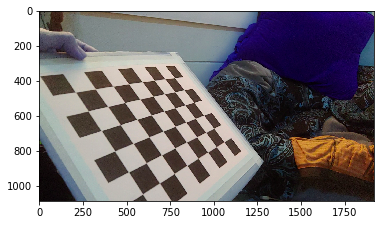

In [47]:
img = cv2.imread(checkerboardImagesListL[6])
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray', vmin=0, vmax=255);

In [48]:
# looks like left image 363 was partially out of the frame, so lets just exclude it:
LcheckerNums = ['00063', '00105', '00169', '00220', '00254', '00324', '00396', '00436', '00455', '00484', '00532', '00592'];
RcheckerNums = ['00463', '00507', '00580', '00642', '00678', '00747', '00830', '00871', '00889', '00918', '00964', '01044'];

# and redefine our list of files:
checkerboardImagesListL = makeImageList(LVidsDirec, LcheckerNums, '.png')
checkerboardImagesListR = makeImageList(RVidsDirec, RcheckerNums, '.png')

In [49]:
# Ok, lets try finding the corners in the left frames again, omitting the one that failed:
imgPtsIDL, imgpointsL, objpointsL, imageListL, failedL = getCamCalImages(checkerboardImagesListL, squareSideLength, squaresHeight, squaresWidth)

In [50]:
# Now lets try the right frames
imgPtsIDR, imgpointsR, objpointsR, imageListR, failedR = getCamCalImages(checkerboardImagesListR, squareSideLength, squaresHeight, squaresWidth)

# and check if any failed in this view
print(failedR)

[]


### OK, looks like we're good! So lets go on to calibrate the cameras

In [51]:
# left first
imageDimensions = imageListL[0][0].shape[::-1]
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpointsL, imgpointsL, imageDimensions,None,None)
camMtxL, roi=cv2.getOptimalNewCameraMatrix(mtxL, distL, imageDimensions, 1, imageDimensions);

# right images (happen to have the same dimensions as left so I'm not redefining imageDimensions)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpointsR, imgpointsR, imageDimensions,None,None)
camMtxR, roiR=cv2.getOptimalNewCameraMatrix(mtxR, distR, imageDimensions, 1, imageDimensions);

# since object points are in an idealized perfectly aligned reference frame, they're identical in both cameras, so we could use either R or L
objpoints = objpointsL;

# use individual camera rotation and translation vectors from idealized aligned position (rvecs and tvecs) 
# to rotation matrices and and translation vector between two cameras
retval, camMtxL2, distL2, camMtxR2, distR2, R, T, E, F = cv2.stereoCalibrate(objpoints, # objectPoints
                                                                             imgpointsL, # imagePoints1
                                                                             imgpointsR, # imagePoints2
                                                                             camMtxL, # cameraMatrix1
                                                                             distL, # distCoeffs1
                                                                             camMtxR, # cameraMatrix2
                                                                             distR, # distCoeffs2
                                                                             (1920, 1088), # imageSize
                                                                             flags = cv2.CALIB_FIX_INTRINSIC) # R=None,T=None,F=None,E=None,criteria=None,

# Get projection matrices for each camera
R1, R2, Pn1, Pn2, Q, _, _ = cv2.stereoRectify(camMtxL, # cameraMatrix1, 
                                              distL, # distCoeffs1, 
                                              camMtxR, # cameraMatrix2, 
                                              distR, # distCoeffs2,
                                              (1920, 1088), 
                                              R, T)

### Ok, so, it took me 4 hours to get stereoCalibrate to work, because the documentation is WRONG
    The documentation says to enter arguments in the following sequence:
    cv2.stereoCalibrate(
        objectPoints, 
        imagePoints1, 
        imagePoints2, 
        imageSize, 
        cameraMatrix1, 
        distCoeffs1, 
        cameraMatrix2, 
        distCoeffs2, 
        optional: R, T, E, F, criteria, 
        flags)
    
    When I run this I get the error message "SystemError: new style getargs format but argument is not a tuple"
    
    I searched for the error message and pretty much just got open message board queries in which people were saying they had the same problem, 
    but no one had replied with any fixes
    
    However, I noticed that the error message indicated that the function expected a tuple in a particular place, and the only input variable that makes sense to be a tuple is imageSize. 
    Therefore, I played around with the order, putting imageSize in different places, until I accidentally hit on the right order.
    So I technically got it to work, in that it didn't error.

### HOWEVER

    If the documentation for this function is garbage, then that makes me think the rest of the python implementation of this package might be a dumpster fire.
    There's other implementation that I'm more familiar with, that I know works (the earlier referenced http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example5.html)
            
    But since I got data through, lets see what it looks like, on the off chance that it actually worked

## Next step:

## 4) track some points, undistort them using undistortPoints, and then triangulate points using triangulatePoints

In [53]:
# I took video of me moving my hand around in front of both cameras, 
# and manually tracked points corresponding to my index finger tip, first knuckle, second knucle, and third knucle

# lets try one frame first

# tracked points coordinates in pixels
                            # finger tip     # first knuckle   # second knuckle   # third knuckle
markerPointsL = np.array([[[548-30, 262-92], [552-30, 310-92], [562-30, 358-92], [558-30, 436-92]]]); # offset (-30, -92)
markerPointsR = np.array([[[794+210, 316+44], [777+210, 369+44], [752+210, 409+44], [704+210, 491+44]]]); # offset(+210, +44)

In [54]:
# Undistort points of interrest
# try turning point arrays sideways
xy_undistortedL = cv2.undistortPoints(markerPointsLRow, camMtxL,  distL)
xy_undistortedR = cv2.undistortPoints(markerPointsRRow, camMtxR,  distR)

#xy_undistortedL = cv2.undistortPoints(src, camMtxL, distCoeffs[, dst[, R, P=None]])

NameError: name 'markerPointsLRow' is not defined

![ChessUrl](https://media.giphy.com/media/7p3e2WCM0VEnm/giphy.gif)

In [ ]:
    I searched the functino and error message, which didn't result in much progress.
    Given that the documentation for another function in the opencv package was wrong, I don't trust anything else in this package
    
    Just as a last ditch effort I'm going to put the un-undistorted points through the triangulation function, since there isn't a ton of distortion in the images I've seen from my cameras

In [55]:
# get triangulated points
points = cv2.triangulatePoints(Pn1,Pn2,markerPointsL,markerPointsR)
print(points)

[[  540080093  1072687634   540080093  1072687634]
 [  540080093  1072687634   540080093  1072687634]
 [ -889512074  1068593619  -889512074  1068593619]
 [-1794400690 -1080350899 -1794400690 -1080350899]]


    The documentation says to expect 4d values, and then transform then to 3d.
    However, it looks like there are only 6 unique values in the returned points.
    This is not what other examples of the output on stack overflow lead me to expect, and the numbers don't make sense for the units I was working in.
    However, the output could conceivably correspond to 3d [x y z] points, so lets plot it anyway.

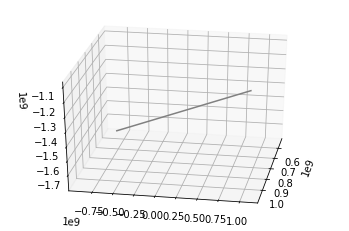

In [56]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D([540080093,1072687634], [-889512074,1068593619], [-1794400690,-1080350899], 'gray')
ax.view_init(30, 10)
plt.draw()

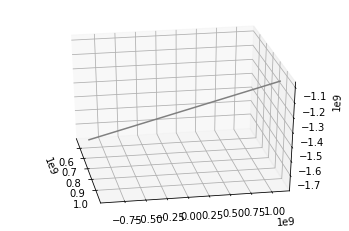

In [58]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D([540080093,1072687634], [-889512074,1068593619], [-1794400690,-1080350899], 'gray')
ax.view_init(30, -10)
plt.draw()

    does not look like an index finger 
    
    ...

# well, if things had worked I'd have progressed through the next steps:

## 5) Get actual data: take high speed video of a subject reaching and grasping
        subject reaches, grasps, retrieves, and consumes a food reward from a platform 
        flash an LED in one fixed corner of the video frame each time the target is reached
        experimenter places a new reward on the platform
        save video file with subject, date, and start time

## 6) Clean the data: synch and separate into trials
    write a function to make sure the video frames are synchronized in time 
        can probably just overwrite timestamps at each LED flash from one video to the other
        may need to interpolate between these frames, if there are slight differences or inconsistencies in frame rate between videos
    write a function to quickly segment video data into trials
        find each frame with an LED flash (signaling when the target is retrieved): time t
        grab all video frames from t-n and t+n frames, where n is half the total time interval desired
            (in other words look in the past a few seconds, and in the future a few seconds, surrounding the retrieval event)
        may want to equalize white balance and contrast etc
        save these video frames into a new individual trial video file, labeled with subject, date, and sequential trial number

## 7) Quantify the data: Turn the video data into numbers
    figure out the right software-hardware combo: tensorflow and GPU.
    install DeepLabCut
    train a network
    analyze top-down and side-on videos seperately
    combine data from both cameras into one 3D coordinates matrix with 3xN entries, where N is the number of frames for that trial
        (if calibration went well the 2D coordinates in each video frame should be in a shared 3D reference frame, 
         with top-down vid giving [x y] coordinates and side-on view giving [y z] coordinates)
    test the network with control data with manually tracked [x y z] coordinates

## 8: Analyze the data: make statistical models
    use cluster analysis to see if there are different "styles" of reaching
        can plot each seperate x, y or z component over time to get a curve
        can cluster curves based on features such as peak height, full width half max, derivatives, degree of polynomial fit, etc
    are the clusters we got statistically different in some more global parameter? Different speeds of retrieval, 

## 9: Interpret the data
¯\\\_(ツ)\_/¯